In [1]:
import os
from astropy.io import fits
import sunpy.map
#from sunpy.coordinates import NorthOffsetFrame
import astropy.units as u
import numpy as np
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames
import matplotlib.pyplot as plt
import matplotlib.colors
import glob
from scipy import ndimage
import numpy as np
import sunpy.timeseries
import scipy.ndimage as ndimage
from scipy.ndimage import label
from scipy.optimize import curve_fit
from scipy.interpolate import RegularGridInterpolator
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

['/home/anu/Desktop/samapti/cycle24(feb-july)/april/hmi.mrdailysynframe_720s.20140408_120000_TAI.data.fits']
2563554
2567814
1.1742566458868416e+18
-1.1742566458868416e+18


/tmp/ipykernel_3128/3302786319.py:265: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc=ax.pcolormesh(x,y,flux, cmap='gray')
/tmp/ipykernel_3128/3302786319.py:290: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc=ax.pcolormesh(x,y,flux, cmap='gray')
/tmp/ipykernel_3128/3302786319.py:312: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and

0
0
0
0
1
1
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
1
1
1
1
0
0
0
0
0
1
1
1
0
0
0
[-5.90917510e+16 -4.00626785e+16 -2.60599420e+16 ...  8.43293482e+15
  4.38435913e+15  2.72141892e+14]
5.751817739418365e+21
1


/tmp/ipykernel_3128/3302786319.py:395: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc=ax.pcolormesh(x,y,flux, cmap='gray',vmin=-100 , vmax=100)


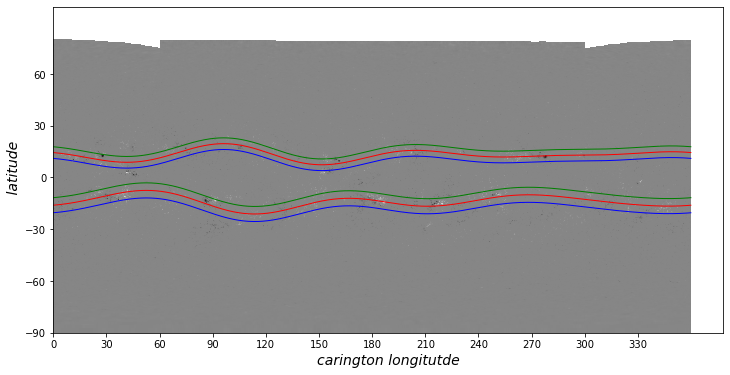

In [44]:

R_sun = 6.96e10

dtr=np.pi/180
rtd=180/np.pi
folder_path = "/home/anu/Desktop/samapti/cycle24(feb-july)/april"

#save_dir1="/home/anu/Desktop/samapti/carrington/synoptic fits files/South hemisphere"
#save_dir2= "/home/anu/Desktop/samapti/carrington/synoptic fits files/North hemisphere"
save_dir4= "/home/anu/Desktop/samapti/2025/june/TF_image"
save_dir3="/home/anu/Desktop/samapti/cycle24(feb-july)/april/patch"
files = os.listdir(folder_path)
fits_files = glob.glob(os.path.join(folder_path, '*.fits'))
for file in fits_files:
    longitude=[]
    longitude_rad=[]
    sinlat=[]
    latitude=[]
    latitude_rad=[]
    coslat=[]
    print(fits_files)
    with fits.open(file)as f:
        header = f[0].header
        data=f[0].data
        data=np.roll(data, -600) 
        nx=data.shape[1]
        ny=data.shape[0]
        #print(f"{nx}  {ny}")
        d_sinlat=2/ny
        dlon_rad=(360/nx)*dtr
        for i in range (ny):
            sin_lat= -1+i*(2/ny)
            Latitude_rad= np.arcsin(sin_lat)
            Latitude =Latitude_rad*rtd
            latitude.append(Latitude)
            sinlat.append(sin_lat)
            cos_lat=np.cos(Latitude_rad)
            coslat.append(cos_lat)
            latitude_rad.append(Latitude_rad)
        for j in range(nx):
            Longitude = 0+j*(360/nx)
            Longitude_rad=Longitude*dtr 
            longitude.append(Longitude)
            longitude_rad.append(Longitude_rad)
        Flux=(data)*(R_sun**2)*(d_sinlat)*(dlon_rad)
        #S= (R_sun**2)*(d_sinlat)*(dlon_rad)
        #print(np.nansum(Flux>0))
        #print(np.nansum(Flux<0))
        #print(S)

        
        
        lon=np.array(longitude)
        lat= np.array(latitude)
        Sinlat=np.array( sinlat)
        Coslat=np.array(coslat)
        latrad=np.array(latitude_rad)
        dlat= np.diff(latrad)
        coslat_avg=np.mean([coslat[0:len(coslat)-1],coslat[1:]],axis=0)
        b=np.multiply(coslat_avg,dlat)
        s=(R_sun**2)*b*(dlon_rad)
        flux=data[:(data.shape[0])-1,]*s.reshape(-1,1)
        print(np.nansum(flux>0))
        print(np.nansum(flux<0))
        #print(s)
        nanrow=[np.nan]*3600
        flux=np.insert(flux,1079,nanrow,axis=0)

        
        x,y=np.meshgrid(lon, lat)
        X,Y=np.meshgrid(lon, Sinlat )
     
        
        fluxthres1= 100*(np.mean(s))                         #1.174257520741785e+18
        fluxthres2= -100*(np.mean(s)) 
        #1.174257520741785e+18
        print(fluxthres1)
        print(fluxthres2)
        
       
        
                      
        binary_mask=(flux>fluxthres1)|(flux<fluxthres2)
        labeled_array, num_features = label(binary_mask)
        totflux=ndimage.sum(flux,labeled_array, range(1, num_features + 1))
        Totflux= np.zeros_like(flux)
        for i, val in enumerate(totflux):
            Totflux[labeled_array == (i + 1)] = val
        regionthres1 = 2e20
        regionthres2 = -2e20
        binary_mask2=(Totflux>regionthres1)| (Totflux<regionthres2)
        y_indices, x_indices = np.where(binary_mask2==1)

        Lat=lat[y_indices]
        Lon=lon[x_indices]
        mask1=(Lat<=0)& (Lat>=-90)
        SH_lat=Lat[mask1]
        SH_lon=Lon[mask1]
        mask2= (Lat<=90) & (Lat>=0)
        NH_lat = Lat[mask2]
        NH_lon = Lon[mask2]
        
        

        sorted_indices1= np.argsort(SH_lon)

        P=SH_lon[sorted_indices1]                                       #P=SHlon_sorted
        Q=SH_lat[sorted_indices1]                                       #Q=SHlat_sorted
        M=np.array(P)
        #print(M)
        
        
        def model1(lon,p,q1,r1):
            S= (lon*np.pi)/180
            return p+q1*np.sin(S+r1)
        Params1, Cov1 = curve_fit(model1,M,Q,method = 'trf')
        #print(f"p = {Params1[0]}, q1 = {Params1[1]}, r1={Params1[2]}")
        SY1=model1(M, *Params1)
        SQ1=np.subtract(Q,SY1)
        mean1=np.mean(SQ1**2)
        rms1=np.sqrt(mean1)
        Error1=model1(lon, *Params1)+rms1
        Error2=model1(lon, *Params1)-rms1
        
        
        def model2(lon,p,q1,r1,q2,r2):
            S= (lon*np.pi)/180
            return p+q1*np.sin(S+r1)+q2*np.sin(2*S+r2)
        Params2, Cov2 = curve_fit(model2,M,Q,method = 'trf')
        #print(f"p = {Params1[0]}, q1 = {Params1[1]}, r1={Params1[2]}")
        SY2=model2(M, *Params2)
        SQ2=np.subtract(Q,SY2)
        mean2=np.mean(SQ2**2)
        rms2=np.sqrt(mean2)
        Error3=model2(lon, *Params2)+rms2
        Error4=model2(lon, *Params2)-rms2
        
        def model3(lon,p,q1,r1,q2,r2,q3,r3):
            S= (lon*np.pi)/180
            return p+q1*np.sin(S+r1)+q2*np.sin(2*S+r2)+q3*np.sin(3*S+r3)
        Params3, Cov3 = curve_fit(model3,M,Q,method = 'trf')
        #print(f"p = {Params1[0]}, q1 = {Params1[1]}, r1={Params1[2]}")
        SY3=model3(M, *Params3)
        SQ3=np.subtract(Q,SY3)
        mean3=np.mean(SQ3**2)
        rms3=np.sqrt(mean3)
        Error5=model3(lon, *Params3)+rms3
        Error6=model3(lon, *Params3)-rms3
        
        def model4(lon,p,q1,r1,q2,r2,q3,r3,q4,r4):
            S= (lon*np.pi)/180
            return p+q1*np.sin(S+r1)+q2*np.sin(2*S+r2)+q3*np.sin(3*S+r3)+q4*np.sin(4*S+r4)
        Params4, Cov4 = curve_fit(model4,M,Q,method = 'trf')
        #print(f"p = {Params1[0]}, q1 = {Params1[1]}, r1={Params1[2]}")
        SY4=model4(M, *Params4)
        SQ4=np.subtract(Q,SY4)
        mean4=np.mean(SQ4**2)
        rms4=np.sqrt(mean4)
        Error7=model4(lon, *Params4)+rms4
        Error8=model4(lon, *Params4)-rms4
        
        def model5(lon,p,q1,r1,q2,r2,q3,r3,q4,r4,q5,r5):
            S= (lon*np.pi)/180
            return p+q1*np.sin(S+r1)+q2*np.sin(2*S+r2)+q3*np.sin(3*S+r3)+q4*np.sin(4*S+r4)+q5*np.sin(5*S+r5)
        Params5, Cov5 = curve_fit(model5,M,Q,method = 'trf')
        #print(f"p = {Params1[0]}, q1 = {Params1[1]}, r1={Params1[2]}")
        SY5=model5(M, *Params5)
        SQ5=np.subtract(Q,SY5)
        mean5=np.mean(SQ5**2)
        rms5=np.sqrt(mean5)
        Error9=model5(lon, *Params5)+rms5
        Error10=model5(lon, *Params5)-rms5
        
        
        
        
        
        
        
        
        
        
        
        
        
        sorted_indices2 = np.argsort(NH_lon)
        A= NH_lon[sorted_indices2]                                              #A=NHlon_sorted=lamda
        B = NH_lat[sorted_indices2]                                             #B= NHlat_sorted=fhi
        N=np.array(A)
        #print(N)
        def model1(lon,a,b1,c1):
            S= (lon*np.pi)/180
            return a+b1*np.sin(S+c1)
        params1, Cov1 = curve_fit(model1,N,B,method = 'trf')
        #print(f"a= {params1[0]}, b= {params1[1]}, c={params1[2]}")
        NY1=model1(N, *params1)
        NB1=np.subtract(B,NY1)
        Mean1=np.mean(NB1**2)
        Rms1=np.sqrt(Mean1)
        error1=model1(lon, *params1)+Rms1
        error2=model1(lon, *params1)-Rms1
        
        def model2(lon,a,b1,c1,b2,c2):
            S= (lon*np.pi)/180
            return a+b1*np.sin(S+c1)+b2*np.sin(2*S+c2)
        params2, Cov2 = curve_fit(model2,N,B,method = 'trf')
        #print(f"a= {params1[0]}, b= {params1[1]}, c={params1[2]}")
        NY2=model2(N, *params2)
        NB2=np.subtract(B,NY2)
        Mean2=np.mean(NB2**2)
        Rms2=np.sqrt(Mean2)
        error3=model2(lon, *params2)+Rms2
        error4=model2(lon, *params2)-Rms2
        
        def model3(lon,a,b1,c1,b2,c2,b3,c3):
            S= (lon*np.pi)/180
            return a+b1*np.sin(S+c1)+b2*np.sin(2*S+c2)+b3*np.sin(3*S+c3)
        params3, Cov3 = curve_fit(model3,N,B,method = 'trf')
        #print(f"a= {params1[0]}, b= {params1[1]}, c={params1[2]}")
        NY3=model3(N, *params3)
        NB3=np.subtract(B,NY3)
        Mean3=np.mean(NB3**2)
        Rms3=np.sqrt(Mean3)
        error5=model3(lon, *params3)+Rms3
        error6=model3(lon, *params3)-Rms3
        
        def model4(lon,a,b1,c1,b2,c2,b3,c3,b4,c4):
            S= (lon*np.pi)/180
            return a+b1*np.sin(S+c1)+b2*np.sin(2*S+c2)+b3*np.sin(3*S+c3)+b4*np.sin(4*S+c4)
        params4, Cov4 = curve_fit(model4,N,B,method = 'trf')
        #print(f"a= {params1[0]}, b= {params1[1]}, c={params1[2]}")
        NY4=model4(N, *params4)
        NB4=np.subtract(B,NY4)
        Mean4=np.mean(NB4**2)
        Rms4=np.sqrt(Mean4)
        error7=model4(lon, *params4)+Rms4
        error8=model4(lon, *params4)-Rms4
        
        def model5(lon,a,b1,c1,b2,c2,b3,c3,b4,c4,b5,c5):
            S= (lon*np.pi)/180
            return a+b1*np.sin(S+c1)+b2*np.sin(2*S+c2)+b3*np.sin(3*S+c3)+b4*np.sin(4*S+c4)+b5*np.sin(5*S+c5)
        params5, Cov5 = curve_fit(model5,N,B,method = 'trf')
        #print(f"a= {params1[0]}, b= {params1[1]}, c={params1[2]}")
        NY5=model5(N, *params5)
        NB5=np.subtract(B,NY5)
        Mean5=np.mean(NB5**2)
        Rms5=np.sqrt(Mean5)
        error9=model5(lon, *params5)+Rms5
        error10=model5(lon, *params5)-Rms5
        
        
                
        
        
        
        
        
        
        
        base_name = os.path.basename(file).replace('.fits', '')
        
        
        
        fig = plt.figure(figsize=(12,6))
        ax=fig.add_subplot(111)
        pc=ax.pcolormesh(x,y,flux, cmap='gray')
        ax.set_xticks(np.arange(0,360,30))
        ax.set_yticks(np.arange(-90,90,30))
        #ax.grid(True)
        
        plt.plot (lon,model1(lon, *Params1), color="Red" ,linewidth=1)
        plt.plot(lon,Error1, color="green",linewidth=1)
        plt.plot(lon,Error2, color="blue",linewidth=1)
       
        plt.plot (lon,model1(lon, *params1), color="Red" ,linewidth=1)
        plt.plot(lon,error1, color="green",linewidth=1)
        plt.plot(lon,error2, color="blue",linewidth=1)
        
        
        plt.xlabel("carington longitutde", color="black", fontsize=14, fontstyle="oblique")
        plt.ylabel(" latitude", color="black", fontsize=14, fontstyle="oblique")
        
        image_name= f" {base_name}_TF1.jpeg"
        mag_image= os.path.join(save_dir3, image_name)
        plt.savefig(mag_image, dpi=300)
        plt.close(fig)
        
        
        fig = plt.figure(figsize=(12,6))
        ax=fig.add_subplot(111)
        pc=ax.pcolormesh(x,y,flux, cmap='gray')
        ax.set_xticks(np.arange(0,360,30))
        ax.set_yticks(np.arange(-90,90,30))
        #ax.grid(True)
        
        plt.plot (lon,model2(lon, *Params2), color="Red" ,linewidth=1)
        plt.plot(lon,Error3, color="green",linewidth=1)
        plt.plot(lon,Error4, color="blue",linewidth=1)
        
        plt.plot (lon,model2(lon, *params2), color="Red" ,linewidth=1)
        plt.plot(lon,error3, color="green",linewidth=1)
        plt.plot(lon,error4, color="blue",linewidth=1)
       
        plt.xlabel("carington longitutde", color="black", fontsize=14, fontstyle="oblique")
        plt.ylabel(" latitude", color="black", fontsize=14, fontstyle="oblique")
        image_name= f" {base_name}_TF2.jpeg"
        mag_image= os.path.join(save_dir3, image_name)
        plt.savefig(mag_image, dpi=300)
        plt.close(fig)
        
        fig = plt.figure(figsize=(12,6))
        ax=fig.add_subplot(111)
        pc=ax.pcolormesh(x,y,flux, cmap='gray')
        ax.set_xticks(np.arange(0,360,30))
        ax.set_yticks(np.arange(-90,90,30))
        #ax.grid(True)
        
        plt.plot (lon,model3(lon, *Params3), color="Red" ,linewidth=1)
        plt.plot(lon,Error5, color="green",linewidth=1)
        plt.plot(lon,Error6, color="blue",linewidth=1)
        
        plt.plot (lon,model3(lon, *params3), color="Red" ,linewidth=1)
        plt.plot(lon,error5, color="green",linewidth=1)
        plt.plot(lon,error6, color="blue",linewidth=1)
      
        
        plt.xlabel("carington longitutde", color="black", fontsize=14, fontstyle="oblique")
        plt.ylabel(" latitude", color="black", fontsize=14, fontstyle="oblique")
        image_name= f" {base_name}_TF3.jpeg"
        mag_image= os.path.join(save_dir3, image_name)
        plt.savefig(mag_image, dpi=300)
        plt.close(fig)
        
        fig = plt.figure(figsize=(12,6))
        ax=fig.add_subplot(111)
        pc=ax.pcolormesh(x,y,flux, cmap='gray')
        ax.set_xticks(np.arange(0,360,30))
        ax.set_yticks(np.arange(-90,90,30))
        #plt.gca().set_aspect("equal")
        #ax.grid(True)
        Output=[]
        for lamda in range(0,360,30):
            for phi in range(-90,90,20):
                ax.add_patch( Rectangle((lamda,phi),30, 20,fc ='none', ec ='none') )
        #ax.add_patch( Rectangle((0,-90),
                        #20, 20,
                        #fc ='none', 
                        #ec ='w',
                phi1, phi2= phi, phi+5
                lamda1, lamda2=lamda, lamda+5
                mask= (x>=lamda1)&(x<lamda2)&(y>=phi1)&(y<phi2)
                flux_values=flux[mask]
                #print(flux_values)
                totflux_values=np.sum(np.abs(flux_values))
                #print(np.abs(totflux_values))
                if (totflux_values>=2e20):
                    print(1)
                else:
                    print(0)
                    
           
        phi1, phi2= -30, -10
        lamda1, lamda2=210, 240
        mask= (x>=lamda1)&(x<lamda2)&(y>=phi1)&(y<phi2)
        flux_values=flux[mask]
        print(flux_values)
        totflux_values=np.sum(flux_values)
        print(np.abs(totflux_values))
        if (np.abs(totflux_values)>=2e20):
            print(1)
        else:
            print(0)
                            

             

        
        plt.plot (lon,model4(lon, *Params4), color="Red" ,linewidth=1)
        plt.plot(lon,Error7, color="green",linewidth=1)
        plt.plot(lon,Error8, color="blue",linewidth=1)
       
        plt.plot (lon,model4(lon, *params4), color="Red" ,linewidth=1)
        plt.plot(lon,error7, color="green",linewidth=1)
        plt.plot(lon,error8, color="blue",linewidth=1)
       
        
        plt.xlabel("carington longitutde", color="black", fontsize=14, fontstyle="oblique")
        plt.ylabel(" latitude", color="black", fontsize=14, fontstyle="oblique")
        image_name= f" {base_name}_TF4.jpeg"
        mag_image= os.path.join(save_dir3, image_name)
        plt.savefig(mag_image, dpi=300)
        #plt.close(fig)
        
        fig = plt.figure(figsize=(12,6))
        ax=fig.add_subplot(111)
        pc=ax.pcolormesh(x,y,flux, cmap='gray',vmin=-100 , vmax=100)
        ax.set_xticks(np.arange(0,360,30))
        ax.set_yticks(np.arange(-90,90,30))
        #ax.grid(True)
        
        plt.plot (lon,model5(lon, *Params5), color="Red" ,linewidth=1)
        plt.plot(lon,Error9, color="green",linewidth=1)
        plt.plot(lon,Error10, color="blue",linewidth=1)
        
        
        plt.plot (lon,model5(lon, *params5), color="Red" ,linewidth=1)
        plt.plot(lon,error9, color="green",linewidth=1)
        plt.plot(lon,error10, color="blue",linewidth=1)
       
        
        plt.xlabel("carington longitutde", color="black", fontsize=14, fontstyle="oblique")
        plt.ylabel(" latitude", color="black", fontsize=14, fontstyle="oblique")
        image_name= f" {base_name}_TF5.jpeg"
        mag_image= os.path.join(save_dir3, image_name)
        #plt.savefig(mag_image, dpi=300)
        plt.close(fig)







In [40]:
data[0:100,0:100]

array([[ 10.283569  ,  10.316516  ,  10.201944  , ..., -15.864692  ,
        -14.651265  , -13.367489  ],
       [  3.7273517 ,   2.1329825 ,   0.72570467, ..., -14.210037  ,
        -12.981817  , -11.503386  ],
       [ -4.983775  ,  -6.4312377 ,  -7.3860116 , ...,  -6.5408006 ,
         -6.3039937 ,  -5.6800895 ],
       ...,
       [  4.3365498 ,   3.3496656 ,   1.7326611 , ..., -11.08091   ,
        -16.852072  , -16.950855  ],
       [  3.4533794 ,   3.7204592 ,   3.4548218 , ..., -13.504278  ,
        -18.387856  , -18.566824  ],
       [  1.3993068 ,   1.4660852 ,   0.11799149, ...,  -8.708637  ,
        -10.240434  , -12.000809  ]], dtype=float32)

In [4]:
R_sun = 6.96e10

dtr=np.pi/180
rtd=180/np.pi
folder_path = "/home/anu/Desktop/samapti/2025/july"
#save_dir1="/home/anu/Desktop/samapti/carrington/synoptic fits files/South hemisphere"
#save_dir2= "/home/anu/Desktop/samapti/carrington/synoptic fits files/North hemisphere"
save_dir4= "/home/anu/Desktop/samapti/2025/july/TF_image"
save_dir3="/home/anu/Desktop/samapti/2025/july/tip_difference"
files = os.listdir(folder_path)
fits_files = glob.glob(os.path.join(folder_path, '*.fits'))
for file in fits_files:
    longitude=[]
    longitude_rad=[]
    sinlat=[]
    latitude=[]
    latitude_rad=[]
    coslat=[]
    print(fits_files)
    with fits.open(file)as f:
        header = f[0].header
        data=f[0].data
        #data=np.roll(data, -600) 
        nx=data.shape[1]
        ny=data.shape[0]
        #print(f"{nx}  {ny}")
        d_sinlat=2/ny
        dlon_rad=(360/nx)*dtr
        for i in range (ny):
            sin_lat= -1+i*(2/ny)
            Latitude_rad= np.arcsin(sin_lat)
            Latitude =Latitude_rad*rtd
            latitude.append(Latitude)
            sinlat.append(sin_lat)
            cos_lat=np.cos(Latitude_rad)
            coslat.append(cos_lat)
            latitude_rad.append(Latitude_rad)
        for j in range(nx):
            Longitude = 0+j*(360/nx)
            Longitude_rad=Longitude*dtr 
            longitude.append(Longitude)
            longitude_rad.append(Longitude_rad)
        #Flux=(data)*(R_sun**2)*(d_sinlat)*(dlon_rad)
        #S= (R_sun**2)*(d_sinlat)*(dlon_rad)
        #print(np.nansum(Flux>0))
        #print(np.nansum(Flux<0))
        #print(S)

        
        
        lon=np.array(longitude)
        lat= np.array(latitude)
        Sinlat=np.array( sinlat)
        Coslat=np.array(coslat)
        latrad=np.array(latitude_rad)
        dlat= np.diff(latrad)
        coslat_avg=np.mean([coslat[0:len(coslat)-1],coslat[1:]],axis=0)
        b=np.multiply(coslat_avg,dlat)
        s=(R_sun**2)*b*(dlon_rad)
        flux=data[:(data.shape[0])-1,]*s.reshape(-1,1)
        print(np.nansum(flux>0))
        print(np.nansum(flux<0))
        #print(s)
        nanrow=[np.nan]*3600
        flux=np.insert(flux,1079,nanrow,axis=0)

        
        x,y=np.meshgrid(lon, lat)
        X,Y=np.meshgrid(lon, Sinlat )
     
        
        fluxthres1= 100*(np.mean(s))                         #1.174257520741785e+18
        fluxthres2= -100*(np.mean(s)) 
        #1.174257520741785e+18
        print(fluxthres1)
        print(fluxthres2)
        
       
        
                      
        binary_mask=(flux>fluxthres1)|(flux<fluxthres2)
        labeled_array, num_features = label(binary_mask)
        totflux=ndimage.sum(flux,labeled_array, range(1, num_features + 1))
        Totflux= np.zeros_like(flux)
        for i, val in enumerate(totflux):
            Totflux[labeled_array == (i + 1)] = val
        regionthres1 = 2e20
        regionthres2 = -2e20
        binary_mask2=(Totflux>regionthres1)| (Totflux<regionthres2)
        y_indices, x_indices = np.where(binary_mask2==1)

        Lat=lat[y_indices]
        Lon=lon[x_indices]
        mask1=(Lat<=0)& (Lat>=-90)
        SH_lat=Lat[mask1]
        SH_lon=Lon[mask1]
        mask2= (Lat<=90) & (Lat>=0)
        NH_lat = Lat[mask2]
        NH_lon = Lon[mask2]
        
        

        sorted_indices1= np.argsort(SH_lon)

        P=SH_lon[sorted_indices1]                                       #P=SHlon_sorted
        Q=SH_lat[sorted_indices1]                                       #Q=SHlat_sorted
        M=np.array(P)
        #print(M)
        sorted_indices2 = np.argsort(NH_lon)
        A= NH_lon[sorted_indices2]                                              #A=NHlon_sorted=lamda
        B = NH_lat[sorted_indices2]                                             #B= NHlat_sorted=fhi
        N=np.array(A)
        

        
        def model3(lon,p,q1,r1,q2,r2,q3,r3):
            S= (lon*np.pi)/180
            return p+q1*np.sin(S+r1)+q2*np.sin(2*S+r2)+q3*np.sin(3*S+r3)
        Params3, Cov3 = curve_fit(model3,M,Q,method = 'trf')
        #print(f"p = {Params1[0]}, q1 = {Params1[1]}, r1={Params1[2]}")
        SY3=model3(M, *Params3)
        SQ3=np.subtract(Q,SY3)
        mean3=np.mean(SQ3**2)
        rms3=np.sqrt(mean3)
        Error5=model3(lon, *Params3)+rms3
        Error6=model3(lon, *Params3)-rms3
        
        def model3(lon,a,b1,c1,b2,c2,b3,c3):
            S= (lon*np.pi)/180
            return a+b1*np.sin(S+c1)+b2*np.sin(2*S+c2)+b3*np.sin(3*S+c3)
        params3, Cov3 = curve_fit(model3,N,B,method = 'trf')
        #print(f"a= {params1[0]}, b= {params1[1]}, c={params1[2]}")
        NY3=model3(N, *params3)
        NB3=np.subtract(B,NY3)
        Mean3=np.mean(NB3**2)
        Rms3=np.sqrt(Mean3)
        error5=model3(lon, *params3)+Rms3
        error6=model3(lon, *params3)-Rms3
        #south_tip=model3(lon, *Params3)
        #abs_southtip=np.abs( south_tip)
        #print(south_tip)
        #print(abs_southtip)
        base_name = os.path.basename(file).replace('.fits', '') 
        tip_difference=np.subtract(model3(lon, *params3),model3(lon, *Params3))
        #tip_difference2=np.subtract(model3(lon, *Params3),model3(lon, *params3))
        #abs_tip_difference2=np.abs(tip_difference2)
        #abstip_difference=np.subtract(model3(lon, *params3),abs_southtip)
        
        
        fig = plt.figure(figsize=(12,6))
        ax=fig.add_subplot(111)
        pc=ax.pcolormesh(x,y,binary_mask2, cmap='gray')
        ax.set_xticks(np.arange(0,360,30))
        ax.set_yticks(np.arange(-90,90,30))
        #ax.grid(True)
        #for lamda in range(0,360,30):
            #for phi in range(-90,90,20):
                #ax.add_patch( Rectangle((lamda,phi),30, 20,fc ='none', ec ='none') )
        #ax.add_patch( Rectangle((0,-90),
                        #20, 20,
                        #fc ='none', 
                        #ec ='w',
                #phi1, phi2= phi, phi+5
                #lamda1, lamda2=lamda, lamda+5
                #mask= (x>=lamda1)&(x<lamda2)&(y>=phi1)&(y<phi2)
                #flux_values=flux[mask]
                #print(flux_values)
                #totflux_values=np.sum(np.abs(flux_values))
                #print(np.abs(totflux_values))
                #if (totflux_values>=2e20):
                   # print(1)
                #else:
                    #print(0)
                #tipdifference=tip_difference[mask]
        
        plt.plot (lon,model3(lon, *Params3), color="Red" ,linewidth=1)
        plt.plot(lon,Error5, color="green",linewidth=1)
        plt.plot(lon,Error6, color="blue",linewidth=1)
        
        plt.plot (lon,model3(lon, *params3), color="Red" ,linewidth=1)
        plt.plot(lon,error5, color="green",linewidth=1)
        plt.plot(lon,error6, color="blue",linewidth=1)
        plt.plot(lon,tip_difference)
        #plt.plot(lon,tip_difference2)
        #plt.plot(lon,abs_tip_difference2,color="red")
        

      
        
        plt.xlabel("carington longitutde", color="black", fontsize=14, fontstyle="oblique")
        plt.ylabel(" latitude", color="black", fontsize=14, fontstyle="oblique")
        image_name= f" {base_name}_TF3.jpeg"
        mag_image= os.path.join(save_dir3, image_name)
        plt.savefig(mag_image, dpi=300)
        plt.close(fig)
        
        
        
        #fig = plt.figure(figsize=(12,6))
        #plt.plot(lon,tip_difference2)
        #fig = plt.figure(figsize=(12,6))
        #plt.plot(lon,abstip_difference,color="pink")
        
        

['/home/anu/Desktop/samapti/2025/july/hmi.mrdailysynframe_720s.20250701_120000_TAI.data.fits']
2553281
2604588
1.1742566458868416e+18
-1.1742566458868416e+18


/tmp/ipykernel_6291/3158851363.py:152: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc=ax.pcolormesh(x,y,binary_mask2, cmap='gray')
